In [267]:
import MySQLdb
from mysql_cred import mysql_user, mysql_passowrd, mysql_database
from pprint import pprint
import pandas as pd
import numpy as np

from IPython.display import Image

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime
import re

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from operator import itemgetter
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

###Setting up the Connection to MySQL

In [3]:
mysql_ip = '158.85.198.80'
mysql_port = 3306
con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)

Function that returns the results of a query to the MySQL database as a Pandas dataframe

In [4]:
def exec_pd(query, printit = False):
    con = MySQLdb.connect(mysql_ip, mysql_user, mysql_passowrd, mysql_database, port = mysql_port)
    cursor = con.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    #pprint(result)
    df = pd.DataFrame.from_records(list(result))
    if printit:
        print df
    return df

#Exploring the BART Data

There are 7 MySQL tables created from the 7 calls that we make every 30 seconds to the BART API. These tables are:

- rout_routeinfo
- rout_routes
- sched_special
- adv_counts
- adv_elev
- adv_bsa
- rt_etd

There are also two other API calls where the results of the calls won't change over time. For these two, we only make one call to the API and stored the results. These tables are: 

- sched_load
- sched_routesched

Below we will explore the data in these tables.

## rout_routeinfo & rout_routes

rout_routeinfo contains information on the routes, direction, and the stations on each route. It turns out that the information in rout_routes do not change over time. So the calls made return redundant results. I wrote the unique values from this table to a textfile in order to avoid having to query the table later.

Also, rout_routes contain exactly the same information is rout_routinfo.

In [13]:
routeinfo = pd.read_csv('routeinfo.txt', sep = '\t')
routeinfo.head()

,sched_num,name,abbr,routeid,number,origin,destination,direction,color,holidays,num_stns,stations
0,35,Pittsburg/Bay Point - SFIA/Millbrae,PITT-SFIA,ROUTE 1,1,PITT,SFIA,NaN,#ffff33,1,26,"PITT,NCON,CONC,PHIL,WCRK,LAFY,ORIN,ROCK,MCAR,1..."
1,35,Millbrae/SFIA - Pittsburg/Bay Point,SFIA-PITT,ROUTE 2,2,SFIA,PITT,NaN,#ffff33,1,26,"MLBR,SFIA,SBRN,SSAN,COLM,DALY,BALB,GLEN,24TH,1..."
2,35,Fremont - Richmond,FRMT-RICH,ROUTE 3,3,FRMT,RICH,NaN,#ff9933,1,18,"FRMT,UCTY,SHAY,HAYW,BAYF,SANL,COLS,FTVL,LAKE,1..."
3,35,Richmond - Fremont,RICH-FRMT,ROUTE 4,4,RICH,FRMT,NaN,#ff9933,1,18,"RICH,DELN,PLZA,NBRK,DBRK,ASHB,MCAR,19TH,12TH,L..."
4,35,Fremont - Daly City,FRMT-DALY,ROUTE 5,5,FRMT,DALY,NaN,#339933,0,19,"FRMT,UCTY,SHAY,HAYW,BAYF,SANL,COLS,FTVL,LAKE,W..."


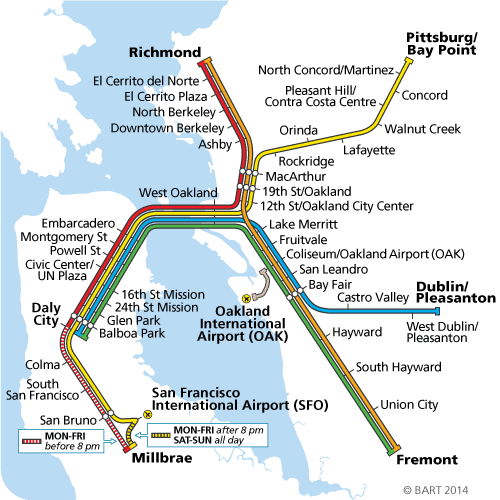

In [16]:
Image(filename='system-map.png') 

##sched_special

There is a an overall schedule governing how BART operates every day. sched_special contains special schedules that are deviations from this general schedule. 

This table can make things pretty complicated. I queried all unique information and the earliest that information was available. we see below that some the information is pretty crucial: "scheduled delays" and "no train service" to name a few.

In [17]:
sched_special = exec_pd('select min(fetchtime) as min_fetchtime, start_date, start_time, \
        end_date, end_time, text_, orig, dest, day_of_week, routes_affected \
        from sched_special group by start_date, start_time, end_date, end_time, \
        text_, orig, dest, day_of_week, routes_affected order by min_fetchtime')
sched_special.columns = ['min_fetchtime', 'start_date', 'start_time', 'end_date', 'end_time', \
                        'text_', 'orig', 'dest', 'day_of_week', 'routes_affected']
sched_special.head(7)

,min_fetchtime,start_date,start_time,end_date,end_time,text_,orig,dest,day_of_week,routes_affected
0,2015-06-04 01:43:04.919920,07/05/2015,06:00,07/05/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,0,"ROUTE 1, ROUTE 2"
1,2015-06-04 01:43:04.919920,07/12/2015,00:01,07/12/2015,12:00,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
2,2015-06-04 01:43:04.919920,07/11/2015,00:01,07/11/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
3,2015-06-04 01:43:04.919920,12/09/2014,23:00,12/31/2015,04:00,AC Transit is running enhanced late night bus ...,None,None,"0, 1, 2, 3, 4, 5, 6","ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."
4,2015-06-04 01:43:04.919920,06/21/2015,06:00,06/21/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,0,"ROUTE 1, ROUTE 2"
5,2015-06-04 01:43:04.919920,06/20/2015,06:00,06/20/2015,15:00,Delays on Pittsburg/Bay Point line,None,None,6,"ROUTE 1, ROUTE 2"
6,2015-06-04 01:43:04.919920,06/14/2015,00:01,06/14/2015,23:59,Bus bridge between Fruitvale and Coliseum,None,None,None,"ROUTE 1, ROUTE 2, ROUTE 3, ROUTE 4, ROUTE 5, R..."


##adv_count

adv_count counts the number of trains active in the system at any point. Below I look at data in one week, and plot the count as a function of time for each day of the week.

In [32]:
#grab the data
adv_count = exec_pd('select distinct date, time, traincount from adv_count')
adv_count.columns = ['date', 'time', 'traincount']

#clean up the date and time
adv_count['date_time'] = adv_count.date + ' ' + adv_count.time
adv_count.date_time = pd.to_datetime(adv_count.date_time, format = "%m/%d/%Y %H:%M:%S %p %Z").astype(datetime.datetime)

#sort table by date_time
adv_count = adv_count.sort('date_time')

adv_count.head()

,date,time,traincount,date_time
12104,06/03/2015,23:43:00 PM PDT,24,2015-06-03 23:43:00
12105,06/03/2015,23:44:00 PM PDT,23,2015-06-03 23:44:00
12106,06/03/2015,23:45:00 PM PDT,23,2015-06-03 23:45:00
12107,06/03/2015,23:46:00 PM PDT,23,2015-06-03 23:46:00
12108,06/03/2015,23:47:00 PM PDT,23,2015-06-03 23:47:00


In [33]:
ac_oneweek =adv_count[(adv_count['date'] < '07/20/2015') & (adv_count['date'] > '07/12/2015')]
ac_monday = ac_oneweek[ac_oneweek['date'] == '07/13/2015']
ac_tuesday = ac_oneweek[ac_oneweek['date'] == '07/14/2015']
ac_wednesday = ac_oneweek[ac_oneweek['date'] == '07/15/2015']
ac_thursday = ac_oneweek[ac_oneweek['date'] == '07/16/2015']
ac_friday = ac_oneweek[ac_oneweek['date'] == '07/17/2015']
ac_saturday = ac_oneweek[ac_oneweek['date'] == '07/18/2015']
ac_sunday = ac_oneweek[ac_oneweek['date'] == '07/19/2015']

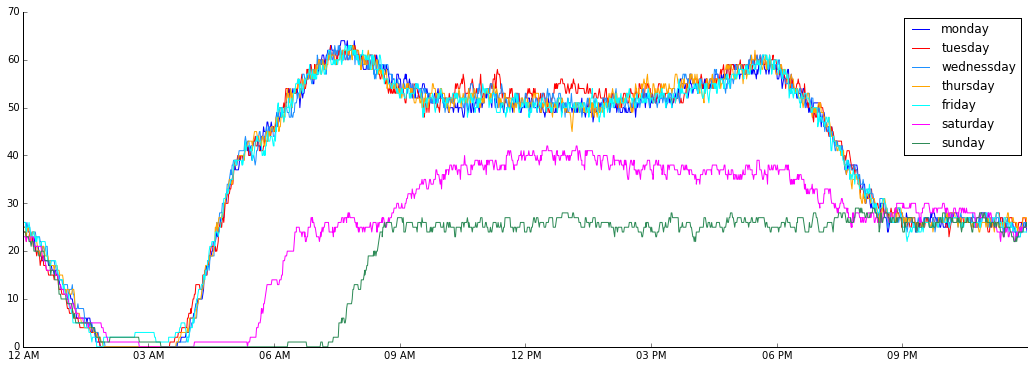

In [46]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)

ax.plot(ac_monday.date_time, ac_monday.traincount, label = 'monday')
ax.plot(ac_tuesday.date_time - datetime.timedelta(hours = 24), 
        ac_tuesday.traincount, label = 'tuesday', color = 'red')
ax.plot(ac_wednesday.date_time - datetime.timedelta(hours = 48), 
        ac_wednesday.traincount, label = 'wednessday', color = 'dodgerblue')
ax.plot(ac_thursday.date_time - datetime.timedelta(hours = 72), 
        ac_thursday.traincount, label = 'thursday', color = 'orange')
ax.plot(ac_friday.date_time - datetime.timedelta(hours = 96), 
        ac_friday.traincount, label = 'friday', color = 'cyan')
ax.plot(ac_saturday.date_time - datetime.timedelta(hours = 120), 
        ac_saturday.traincount, label = 'saturday', color = 'magenta')
ax.plot(ac_sunday.date_time - datetime.timedelta(hours = 144), 
        ac_sunday.traincount, label = 'sunday', color = 'seagreen')

date_format = mdates.DateFormatter('%I %p')
ax.xaxis.set_major_formatter(date_format)

plt.legend()
remove_border()
plt.show()

Above we plot a representative week of train counts. For weekdays, the counts are very close, while for Saturday and Sunday we see a lower volume.

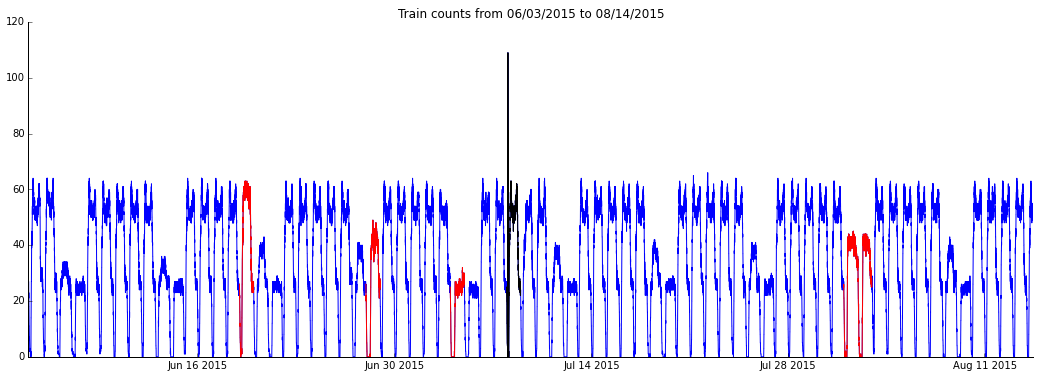

In [49]:
plt.figure(figsize=(18, 6))
plt.plot(adv_count.date_time, adv_count.traincount)

plt.plot(adv_count.date_time[adv_count['date'] == '06/19/2015'], 
         adv_count.traincount[adv_count['date'] == '06/19/2015'], '-r')
plt.plot(adv_count.date_time[adv_count['date'] == '06/28/2015'], 
         adv_count.traincount[adv_count['date'] == '06/28/2015'], '-r')
plt.plot(adv_count.date_time[adv_count['date'] == '07/04/2015'], 
         adv_count.traincount[adv_count['date'] == '07/04/2015'], '-r')
plt.plot(adv_count.date_time[adv_count['date'] == '08/01/2015'], 
         adv_count.traincount[adv_count['date'] == '08/01/2015'], '-r')
plt.plot(adv_count.date_time[adv_count['date'] == '08/02/2015'], 
         adv_count.traincount[adv_count['date'] == '08/02/2015'], '-r')

plt.plot(adv_count.date_time[adv_count['date'] == '07/08/2015'], 
         adv_count.traincount[adv_count['date'] == '07/08/2015'], '-k')


plt.title("Train counts from " + str(min(adv_count.date)) + " to " + str(max(adv_count.date)))
remove_border()
plt.show()

Looking at data for the entire length of time we have been collecting, we see a couple of interesting outlier behaviors: 

- **June 19**: In the Second full week on friday we see a abnormally high activity. It turns out this corresponds to the Warriors Championship parade
- **June 28**: the following Sunday we see another unusually high volume of trains, this time corresponding the Pride Parade in SF. 
- **July 4**: The following weekend on Saturday, we see lower than normal volume on Independence Day as many people go out of town.
- **August 1 and 2**: The second to last full weekend depicted below also show unsually high volume of trains, related to the closure of the transbay tube for repairs.

There is also a hugh spike (actually 2 of them) on **July 8**. it appears this is just bad data. There are only two instances where the count of trains is above 80. The average of counts for trains for those hours (see below).

In [57]:
print adv_count[adv_count['traincount'] > 80]
print
print "2:32am avg: " + str(adv_count[adv_count['time'] == '02:32:00 AM PDT'].traincount.mean())
print "3:15am avg: "+ str(adv_count[adv_count['time'] == '03:15:00 AM PDT'].traincount.mean())

             date             time  traincount            date_time
50693  07/08/2015  02:32:00 AM PDT         109  2015-07-08 02:32:00
50736  07/08/2015  03:15:00 AM PDT          81  2015-07-08 03:15:00

2:32am avg: 2.125
3:15am avg: 1.55555555556


##adv_elev

adv_elev provides information on any elevator adivsories in the BART system. We originally included this call because we suspected out-of-order elevators at a station could affect how fast people get out of the station, or could correlate with other equipment problems at a station.

In [62]:
adv_elev = exec_pd('select min(fetchtime) as min_fetchtime, description \
from adv_elev group by description')
adv_elev.columns = ['min_fetchtime', 'description']
adv_elev = adv_elev.sort('min_fetchtime')
adv_elev.head()

,min_fetchtime,description
215,2015-06-04 01:43:04.919920,There is one elevator out of service at this t...
30,2015-06-04 06:05:46.322038,There are no elevators out of service at this ...
206,2015-06-04 06:38:17.735498,There is one elevator out of service at this t...
211,2015-06-05 11:39:25.606226,There is one elevator out of service at this t...
230,2015-06-05 14:24:31.743054,There is one elevator out of service at this t...


Looking at the unique values of the description field...

In [68]:
desc = list(adv_elev.description.unique())
print "number of unique values: "+str(len(desc))
print "\nsample:"
for d in desc[:5]:
    print d

number of unique values: 253

sample:
There is one elevator out of service at this time:  Coliseum Platform Elevator.  Thank you.
There are no elevators out of service at this time.  Thank you.
There is one elevator out of service at this time:  19th St. Oakland Street Elevator.  Thank you.
There is one elevator out of service at this time:  Berkeley Street Elevator.  Thank you.
There is one elevator out of service at this time:  MacArthur S.F./Fremont Platform Elevator.  Thank you.


With a quick look at the descriptions, we see a pattern among the different values: the description almost always contain the words "out of service at this time". The number preceding the phrase indicates the number of elevators out. There are only two case where the phrase above is not in the description: one is a NULL value, and the other refers to when all elevators are in service (see below):

In [78]:
print "descriptions without 'out of service at this time':"
print [x for x in desc if type(x) == str and 'out of service at this time' not in x.lower()]
print
print "descriptions with 'in service':"
print [x for x in desc if type(x) == str and 'in service'in x.lower()]

descriptions without 'out of service at this time':
['Attention passengers: All elevators are in service. Thank You.', 'ALL STATION ELEVATORS ARE IN SERVICE.']

descriptions with 'in service':
['Attention passengers: All elevators are in service. Thank You.', 'ALL STATION ELEVATORS ARE IN SERVICE.']


Two simple rules can explain how many elevators are out: 

- look for word after is/are: 
    - if a number, then that number
    - if no or in, then zero

In [103]:
#convert min_fetchtime to a datetime
adv_elev['min_fetchtime_dt'] = pd.to_datetime(
    adv_elev.min_fetchtime, format = "%Y-%m-%d %H:%M:%S.%f").astype(datetime.datetime)

num_dict = {'no': 0, 'in':0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7}
desc = list(adv_elev.description)
elevs_out = []

for t in desc:
    try:
        elevs_out.append(num_dict[re.search('(is|are) (.*?) ', str(t.lower())).group(2)])
    except:
        elevs_out.append(0)

adv_elev['elevs_out'] = elevs_out
adv_elev.head(5)

,min_fetchtime,description,elevs_out,min_fetchtime_dt,hours
215,2015-06-04 01:43:04.919920,There is one elevator out of service at this t...,1,2015-06-04 01:43:04.919920,1
30,2015-06-04 06:05:46.322038,There are no elevators out of service at this ...,0,2015-06-04 06:05:46.322038,6
206,2015-06-04 06:38:17.735498,There is one elevator out of service at this t...,1,2015-06-04 06:38:17.735498,6
211,2015-06-05 11:39:25.606226,There is one elevator out of service at this t...,1,2015-06-05 11:39:25.606226,11
230,2015-06-05 14:24:31.743054,There is one elevator out of service at this t...,1,2015-06-05 14:24:31.743054,14


Below we should the number of elevators out in the whole BART system over the period of time we have data.

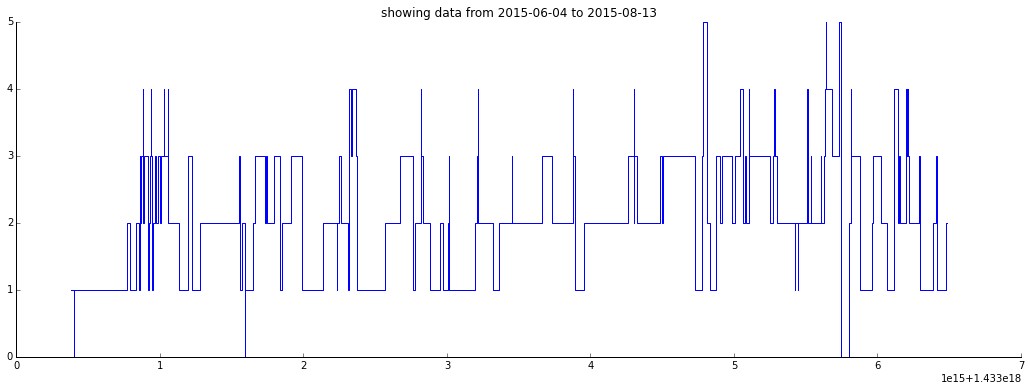

In [100]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)

ax.step(adv_elev.min_fetchtime_dt, adv_elev.elevs_out, where='post')
plt.title("showing data from " + str(min(adv_elev.min_fetchtime_dt).date()) +
          " to " + str(max(adv_elev.min_fetchtime_dt).date()))

remove_border()
plt.show()

##adv_bsa

adv_bsa contains all the official advisories BART publishes as it relates to delays.

In [104]:
adv_bsa = exec_pd('select min(fetchtime) as min_fetchtime, description \
from adv_bsa group by description')
adv_bsa.columns = ['min_fetchtime', 'description']
adv_bsa = adv_bsa.sort('min_fetchtime')
adv_bsa.head()

,min_fetchtime,description
156,2015-06-04 01:43:04.919920,No delays reported.
235,2015-06-04 18:58:16.741598,There is a 10-minute delay on the Daly City Li...
85,2015-06-04 19:04:46.981092,BART is recovering from an earlier problem. Th...
133,2015-06-04 19:09:47.169302,BART is recovering from an earlier problem. Th...
370,2015-06-04 19:39:18.246734,There is a major delay system wide due to an e...


Intepreting the delay message can be complicated, given that it appears there is a strict rule in place in terms of the format of the text description. this steers us away from interpretting delays from the advisory messages.

##sched_load

sched_load is one of the API calls we made only once, since the information does not change. The load values are estimates tied to route, train, and station. Light load corresponds to 1, the next level is 2, and high load is coded as 3. We only have load data for Weekdays.

In [109]:
sched_load = exec_pd('select station, route, train, passload from sched_load;')
sched_load.columns = ['station', 'route', 'train', 'passload']
sched_load.head()

,station,route,train,passload
0,SHAY,3,1,1
1,SHAY,3,2,1
2,SHAY,3,3,1
3,SHAY,3,4,1
4,SHAY,3,5,1


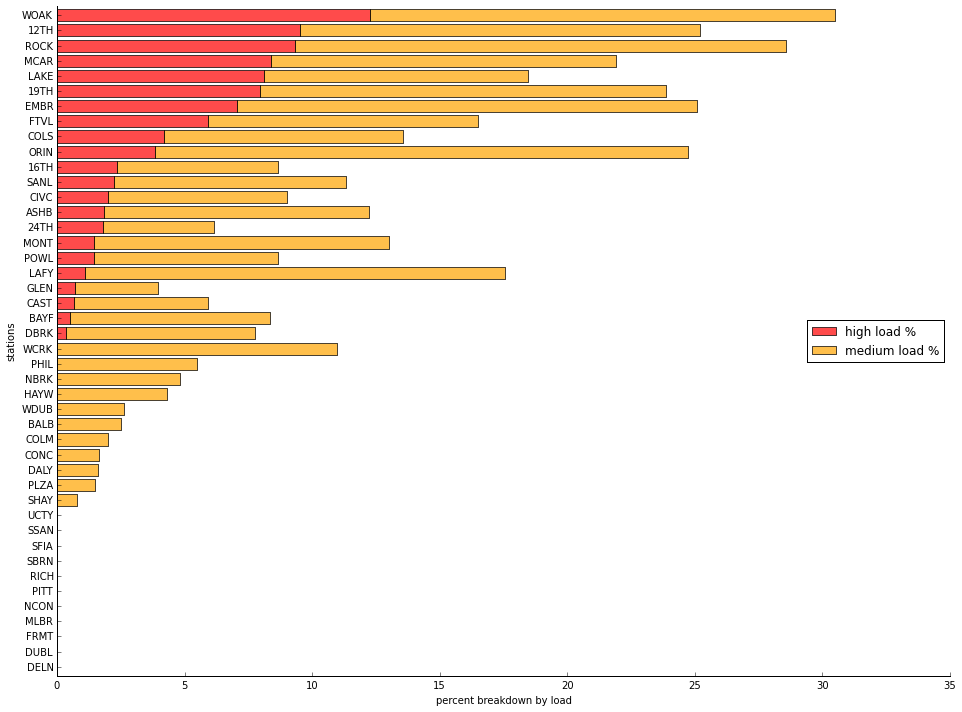

In [110]:
# pivot the data on load and station. values are percentages.
piv = pd.pivot_table(sched_load, columns = 'passload', index = 'station', values = 'route', aggfunc=lambda x: len(x))
piv = piv.apply(lambda x : x * 100 / x.sum(), axis=1)
piv = piv.fillna(0)
piv = piv.sort([3, 2], ascending=[1, 1])

fig, ax = plt.subplots(figsize=(16,12))
labels = piv.index
locations = np.arange(len(labels))
width = 2

ax.barh(locations, piv[3], align='center', alpha=0.7, color = 'red')
ax.barh(locations, piv[2], align='center', alpha=0.7, left = piv[3], color = 'orange')
plt.yticks(locations, labels)
ax.set_ylim(min(locations) - 0.6, max(locations) + 0.6)
ax.set_xlabel('percent breakdown by load')
ax.set_ylabel('stations')
ax.legend(('high load %', 'medium load %'), loc = 5)

remove_border()

There are clearly some stations where there is a lot more passenger load, and a number of stations where we see no high or medium load. The top stations (top 8: West Oakland, 12th St., Rockridge, McArthur, Lake Merritt, 19th St., Embarcadero, and Fruitvale) are all central to the system map, which makes sense. The low load stations are all on the edges of the map.

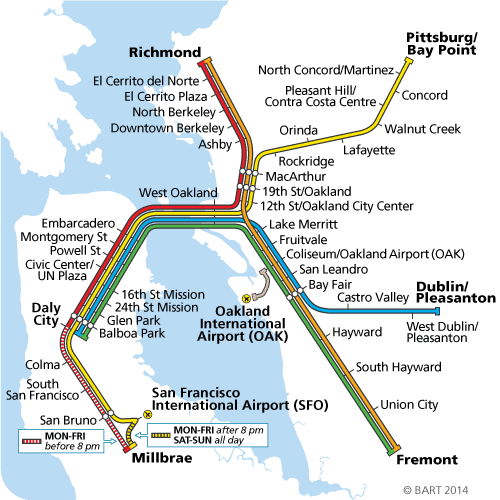

In [108]:
Image(filename='system-map.png')

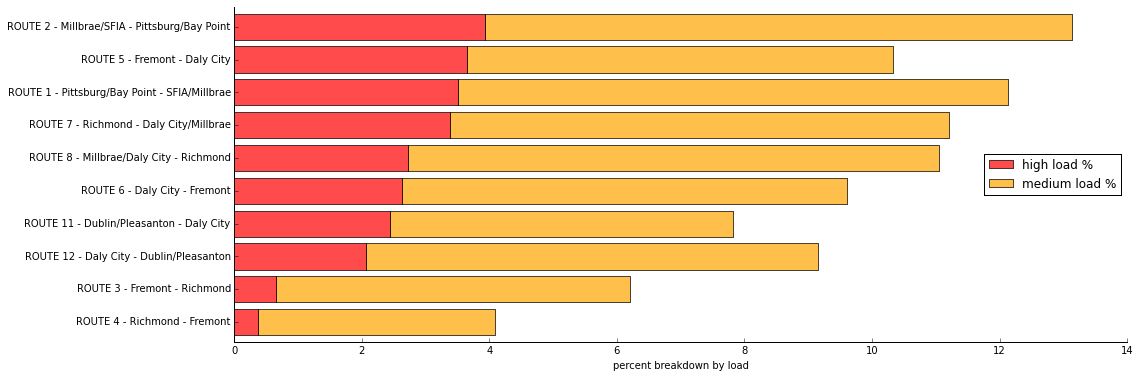

In [111]:
#pivot on load and route.
piv = pd.pivot_table(sched_load, columns = 'passload', index = 'route', values = 'station', aggfunc=lambda x: len(x))
piv = piv.apply(lambda x : x * 100 / x.sum(), axis=1)
piv = piv.fillna(0)
piv = piv.sort([3, 2], ascending=[1, 1])
piv['route'] = piv.index
piv = piv.merge(routeinfo, left_on = 'route', right_on = 'number')

fig, ax = plt.subplots(figsize=(16, 6))
labels = piv.routeid + " - " + piv.name
locations = np.arange(len(labels))
width = 2

ax.barh(locations, piv[3], align='center', alpha=0.7, color = 'red')
ax.barh(locations, piv[2], align='center', alpha=0.7, left = piv[3], color = 'orange')

plt.yticks(locations, labels)
ax.set_ylim(min(locations) - 0.6, max(locations) + 0.6)
ax.set_xlabel('percent breakdown by load')
ax.legend(('high load %', 'medium load %'), loc = 5)

remove_border()

Aside from routes 3 and 4, we see between 2 to 4% of high load in each route. 3 and 4 don't cross the bay, so it makes sense that they don't see as much load. There is no load information for routes 19 and 20, which move between Coliseum and Oakland Airport.

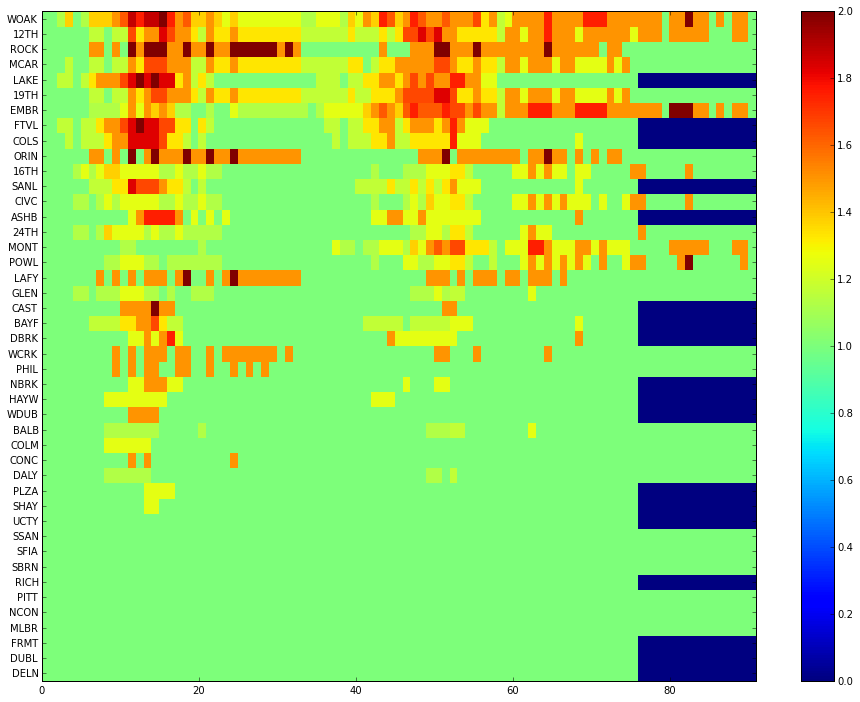

In [112]:
stations_by_load = ['DELN', 'DUBL', 'FRMT', 'MLBR', 'NCON', 'PITT', 'RICH', 'SBRN', 'SFIA', 'SSAN', 'UCTY', 'SHAY',\
                    'PLZA', 'DALY', 'CONC', 'COLM', 'BALB', 'WDUB', 'HAYW', 'NBRK', 'PHIL', 'WCRK', 'DBRK', 'BAYF',\
                    'CAST', 'GLEN', 'LAFY', 'POWL', 'MONT', '24TH', 'ASHB', 'CIVC', 'SANL', '16TH', 'ORIN', 'COLS',\
                    'FTVL', 'EMBR', '19TH', 'LAKE', 'MCAR', 'ROCK', '12TH', 'WOAK']

piv = pd.pivot_table(sched_load, columns = 'train', index = ['station'], values = 'passload').T
piv = piv.fillna(0)

piv = piv[stations_by_load].T
fig, ax = plt.subplots(figsize=(16,12))
labels = piv.index

locations = np.arange(len(labels))+0.5

cax = ax.pcolor(piv)
fig.colorbar(cax)
plt.yticks(locations, labels)
cax = ax.set_ylim(0, max(locations) + 0.5)
cax = ax.set_xlim(0,91)


Yet another way to visualize the load. The above depiction is not a perfection representation of load over time, as the train schedules for one route might be different than others. But the above gives an indication of where we see most of the load.

##sched_routesched

sched_routesched is another one-time call we made to the BART API, and reflects the scheduled departure time of trains. We use this dataset along with the actual schedules to measure delays.

In [113]:
columns = ['day', 'route', 'train', 'station', 'origtime', 'bikeflag']
sched_routesched = exec_pd('select day, route, train, station, origtime, bikeflag from sched_routesched')
sched_routesched.columns = columns
sched_routesched['time'] = pd.to_datetime(sched_routesched['origtime'], '%I:%M %p')
sched_routesched.head()

,day,route,train,station,origtime,bikeflag,time
0,wd,1,1,PITT,4:02 AM,1,4:02 AM
1,wd,1,1,NCON,4:08 AM,1,4:08 AM
2,wd,1,1,CONC,4:12 AM,1,4:12 AM
3,wd,1,1,PHIL,4:17 AM,1,4:17 AM
4,wd,1,1,WCRK,4:20 AM,1,4:20 AM


In [129]:
load_routesched = sched_load.merge(sched_routesched[sched_routesched['day']=='wd'], on = ['route', 'train', 'station'])
load_routesched['time'] = pd.to_datetime(load_routesched['origtime'], '%I:%M %p').astype(datetime.datetime)

In [130]:
load_routesched.head()

,station,route,train,passload,day,origtime,bikeflag,time
0,SHAY,3,1,1,wd,4:10 AM,1,2015-08-14 04:10:00
1,SHAY,3,2,1,wd,4:25 AM,1,2015-08-14 04:25:00
2,SHAY,3,3,1,wd,4:40 AM,1,2015-08-14 04:40:00
3,SHAY,3,4,1,wd,4:55 AM,1,2015-08-14 04:55:00
4,SHAY,3,5,1,wd,5:10 AM,1,2015-08-14 05:10:00


bad data...

In [74]:
sched_routesched[sched_routesched['station']=='NULL']

,day,route,train,station,origtime,bikeflag,time
30030,su,5,0,NULL,NULL,0,NULL
30031,su,6,0,NULL,NULL,0,NULL
30032,su,7,0,NULL,NULL,0,NULL
30033,su,8,0,NULL,NULL,0,NULL


##rt_etd

rt_etd provides realtime BART data. The column "minutes" indicates, at any point" how many minutes are left until the next train arrives at a station. When the train is at or very close to the station, the value of "minutes" changes from a number to "Leaving". This is, in principal, how we indicate when a train is at a station.

In [75]:
print list(exec_pd('describe rt_etd')[0])

['uid', 'fetchtime', 'date', 'time', 'name', 'abbr', 'destination', 'abbreviation', 'minutes', 'platform', 'direction', 'length', 'color', 'hexcolor', 'bikeflag']


In [165]:
mins = exec_pd("select case when minutes = 'Leaving' then 0 else minutes end as mins, \
        count(*) as cnt from rt_etd group by mins order by mins")
mins.columns = ['minutes', 'cnt']
mins['minutes'] = mins['minutes'].astype(float)
mins.head()

,minutes,cnt
0,0,2178705
1,1,1044547
2,10,1777420
3,100,14221
4,101,12760


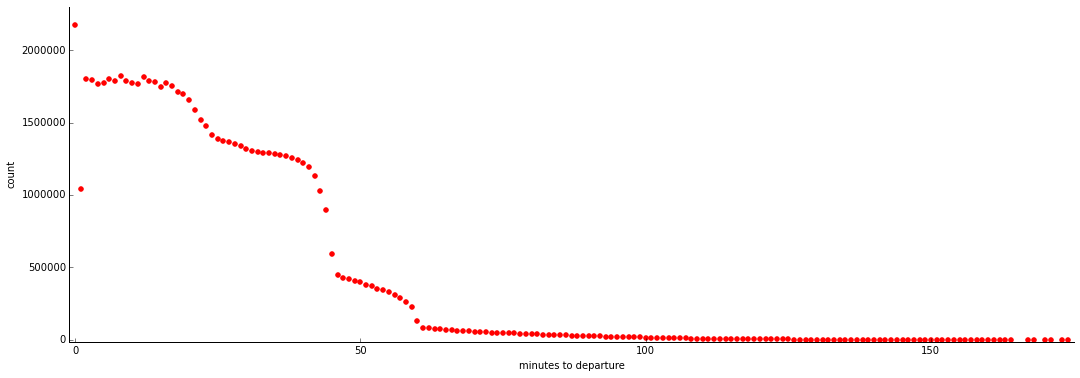

In [166]:
plt.figure(figsize=(18, 6))
plt.scatter(mins.minutes, mins.cnt, color = 'red')
plt.xlim(-1, 175)
plt.ylim(-15000, 2300000)
plt.xlabel('minutes to departure')
plt.ylabel('count')
remove_border()
plt.show()

The distribution of the "minutes to departure" is very interesting. We see that "Leaving" (converted to 0 above) is by far the most prevelant value, and then we see a huge dropoff at 1. This indicates that BART has a bias toward indicating that the train is at the station, rather than saying it is a minute away. This potentially can (and will) be problematic for us.

It is also interesting to note the three big "humps" in the plot above. BART only announces the real-time data for the closest three trains. In addition, there are generally three groups of stations when we consider distances between stations: Some station are very close to each other (think Embarcadero, Montgomery, Powell, and Civic Center), some stations are a bit further apart (think Lake Merritt, Fruitvale, and Coliseum), and then we have stations that are further apart (Embarcadero and West Oakland, McArthur and Ashby). These variations in distance are reflected in the three humps we see in the plot above.

#Data Prep for Modeling

As a first attempt we chose to look at the **Rockridge** station as the one station we want to predict delays for. It only sits on one route for each direction, and according to loads it is a pretty busy station, which mean we probably will have more delays to work with. I chose the Milbrae-Pittsburgh direction, since it is coming from across the Bay and is most likely carrying more passengers in that direction.

In [168]:
print "count of all records: "
print exec_pd('select count(*) from rt_etd')
print "count of records for the Rockridge station in the PITT direction: "
print exec_pd("select count(*) from rt_etd where abbr = 'ROCK' and abbreviation = 'PITT'")

count of all records: 
          0
0  75368836
count of records for the Rockridge station in the PITT direction: 
        0
0  521859


In [169]:
rock = exec_pd("select * from rt_etd where abbr = 'ROCK' and abbreviation = 'PITT'")
rock.columns = list(exec_pd('describe rt_etd')[0])
rock['date_time'] = rock['date']+' '+rock['time']
rock['date_time'] = pd.to_datetime(rock['date_time'], format = "%m/%d/%Y %I:%M:%S %p %Z")#.astype(datetime.datetime)
rock = rock.sort('date_time')
rock = rock[['date_time', 'date', 'minutes', 'length']]
rock.head()

,date_time,date,minutes,length
287980,2014-11-06 15:12:04,11/06/2014,4,10
287981,2014-11-06 15:12:04,11/06/2014,19,9
287982,2014-11-06 15:12:04,11/06/2014,33,10
58451,2015-06-03 23:42:51,06/03/2015,66,5
58449,2015-06-03 23:42:51,06/03/2015,18,5


##Distinguishing different trains arriving at a station

There are instances where we have two records consecutively saying 'Leaving'. These records could belong to the same instance of a train at the station. In an ideal situation we would start from the top of the list, and whever we hit a 'Leaving', we account that, and ignore the other ones that are attached to it.

However, the above doesn't work, because there is also the possibility that two trains are lined up, one after the other, and as soon as one leaves the other one arrives. This is additionally more likely due to the bias revealed earlier to assign 'Leaving' to a train that is very close to the station. 

Another alternative is to set a threshold, say 50 seconds, and assume that if we have two 'Leaving's more than 50 seconds away from each other they are separate trains.

In [179]:
rock_l = rock[rock['minutes'] == 'Leaving']
rock_l = rock_l.reset_index(drop = True)
rock_l['gap'] = 80

for i in rock_l.index:
    try:
        rock_l.loc[i, 'gap'] = (rock_l.ix[i]['date_time'] - rock_l.ix[i-1]['date_time']).total_seconds()
    except:
        pass

rock_l.head()

,date_time,date,minutes,length,gap
0,2015-06-04 00:00:18,06/04/2015,Leaving,5,80
1,2015-06-04 00:25:06,06/04/2015,Leaving,5,1488
2,2015-06-04 00:25:33,06/04/2015,Leaving,5,27
3,2015-06-04 00:52:33,06/04/2015,Leaving,5,1620
4,2015-06-04 00:53:03,06/04/2015,Leaving,5,30


Another complication comes from distinguishing "train days". The earliest train every day is around 4 or 5am, and trains usually run until around 12:30 or 1am. So we shift the date_time by two hours, essentially starting a "train day" as 2am and ending it at 2am the day after.

In [180]:
rock_l['train_date_time'] = rock_l['date_time'] - datetime.timedelta(hours = 2)
rock_l.head()

,date_time,date,minutes,length,gap,train_date_time
0,2015-06-04 00:00:18,06/04/2015,Leaving,5,80,2015-06-03 22:00:18
1,2015-06-04 00:25:06,06/04/2015,Leaving,5,1488,2015-06-03 22:25:06
2,2015-06-04 00:25:33,06/04/2015,Leaving,5,27,2015-06-03 22:25:33
3,2015-06-04 00:52:33,06/04/2015,Leaving,5,1620,2015-06-03 22:52:33
4,2015-06-04 00:53:03,06/04/2015,Leaving,5,30,2015-06-03 22:53:03


Below we can see a distribution of gaps between the different "Leaving" values (log scaled). We iterated on trying various cutoffs as a heursitic threshold for distinguishing between the different trains, and arrived as 54 as the best cutoff.

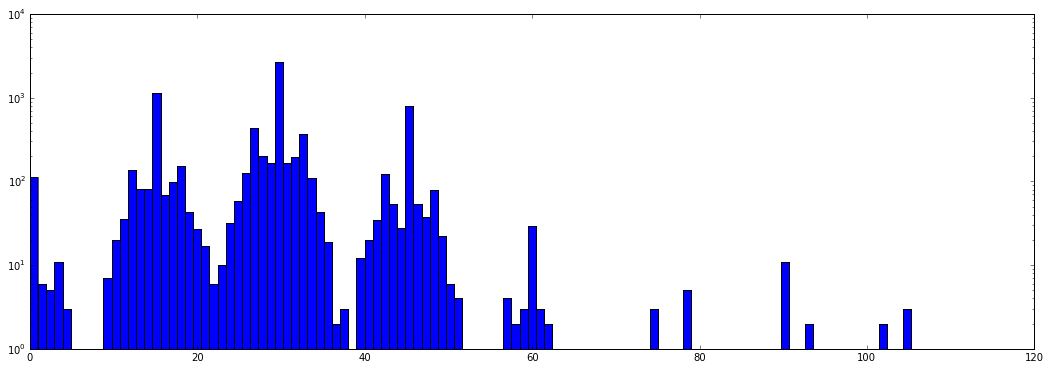

In [181]:
gaps = rock_l['gap'][rock_l['gap'] < 120]
ax = plt.figure(figsize=(18, 6))
ax = plt.hist(gaps, 120, log = True)

In [182]:
rock_l = rock_l[['train_date_time', 'date_time', 'date', 'length']][rock_l['gap'] >= 54]
rock_l['train_date'] = rock_l['train_date_time'].apply(lambda x: str(x.date()))
rock_l['day'] = rock_l['date_time'].apply(lambda x: np.where(x.isoweekday() < 6, 'wd',\
                                                                  np.where(x.isoweekday()==6, 'sa', 'su')))
rock_l.head()

,train_date_time,date_time,date,length,train_date,day
0,2015-06-03 22:00:18,2015-06-04 00:00:18,06/04/2015,5,2015-06-03,wd
1,2015-06-03 22:25:06,2015-06-04 00:25:06,06/04/2015,5,2015-06-03,wd
3,2015-06-03 22:52:33,2015-06-04 00:52:33,06/04/2015,5,2015-06-03,wd
5,2015-06-04 02:46:05,2015-06-04 04:46:05,06/04/2015,5,2015-06-04,wd
7,2015-06-04 03:05:06,2015-06-04 05:05:06,06/04/2015,10,2015-06-04,wd


Above we have actual arrival times of Milbrae-Pittsburg trains at Rockridge station. We want to compare these with scheduled arrival times, which are stored in the sched_routesched table.

In [175]:
columns = ['day', 'route', 'train', 'station', 'origtime']
sched_routesched = exec_pd("select day, route, train, station, origtime \
    from sched_routesched where route = '2' and station = 'ROCK'")
sched_routesched.columns = columns

,day,route,train,station,origtime
192,su,2,46,ROCK,11:20 PM
193,su,2,47,ROCK,11:40 PM
194,su,2,48,ROCK,12:00 AM
195,su,2,49,ROCK,12:25 AM
196,su,2,50,ROCK,12:47 AM


In [183]:
daysdf = rock_l[['date','day']].drop_duplicates().reset_index(drop = True)
sched = daysdf.merge(sched_routesched, how = 'left', on = 'day')
sched['date_time'] = sched['date']+' '+sched['origtime']
sched['date_time'] = pd.to_datetime(sched['date_time'], format = "%m/%d/%Y %I:%M %p")
sched['train_date_time'] = sched['date_time'] - datetime.timedelta(hours = 2)
sched = sched.sort(['train_date_time']).reset_index(drop = True)
sched['train_date'] = sched['train_date_time'].apply(lambda x: str(x.date()))
sched.head()

,date,day,route,train,station,origtime,date_time,train_date_time,train_date
0,06/04/2015,wd,2,89,ROCK,12:00 AM,2015-06-04 00:00:00,2015-06-03 22:00:00,2015-06-03
1,06/04/2015,wd,2,90,ROCK,12:25 AM,2015-06-04 00:25:00,2015-06-03 22:25:00,2015-06-03
2,06/04/2015,wd,2,91,ROCK,12:47 AM,2015-06-04 00:47:00,2015-06-03 22:47:00,2015-06-03
3,06/04/2015,wd,2,1,ROCK,4:44 AM,2015-06-04 04:44:00,2015-06-04 02:44:00,2015-06-04
4,06/04/2015,wd,2,2,ROCK,4:59 AM,2015-06-04 04:59:00,2015-06-04 02:59:00,2015-06-04


In [187]:
print "number of trains scheduled: " + str(sched.shape[0])
print "number of actual trains: "+ str(rock_l.shape[0])
print

r = pd.DataFrame(rock_l.groupby('train_date').date.count())
r['d'] = r.index
s = pd.DataFrame(sched.groupby('train_date').date.count())
s['d'] = s.index
m = r.merge(s, on = 'd', suffixes = ['_r', '_s'])
print 'total days we have data for: '+ str(len(m))
print 'days with matching records:', sum(m.date_s == m.date_r)

number of trains scheduled: 5792
number of actual trains: 5461

total days we have data for: 73
days with matching records: 11


Ideally, the number of trains scheduled to arrive at Rockridge match the number of trains that actually arrive at the station. However, this is not the case. We tried playing around with the threshold we set above to distinguish between different trains, but there will always be a mismatch. So we need to come up with a way of matching actual times to scheduled times the best way possible.

Also worth mentioning is that we also explored the posssibility that BART actually throttles how many trains it sends, explaining why we see fewer than scheduled arrivals. Based on our research, however, this is not the case.

##Top Approaches:

We break down the dataset by "train day". In each day, we first make a backward pass on the actual times, associating each actual time to a smaller scheduled time that is closest to it. After we have gone through the actual times, we then make a foward pass on the records in the scheduled dataset that were not associated to an actual time. In this forward pass, we associate each scheduled time to the smallest actual value larger than the scheduled time.

This makes sense because we are assuming there are trains arriving that are too close to each other and we cannot distinguish with our level of granularity.

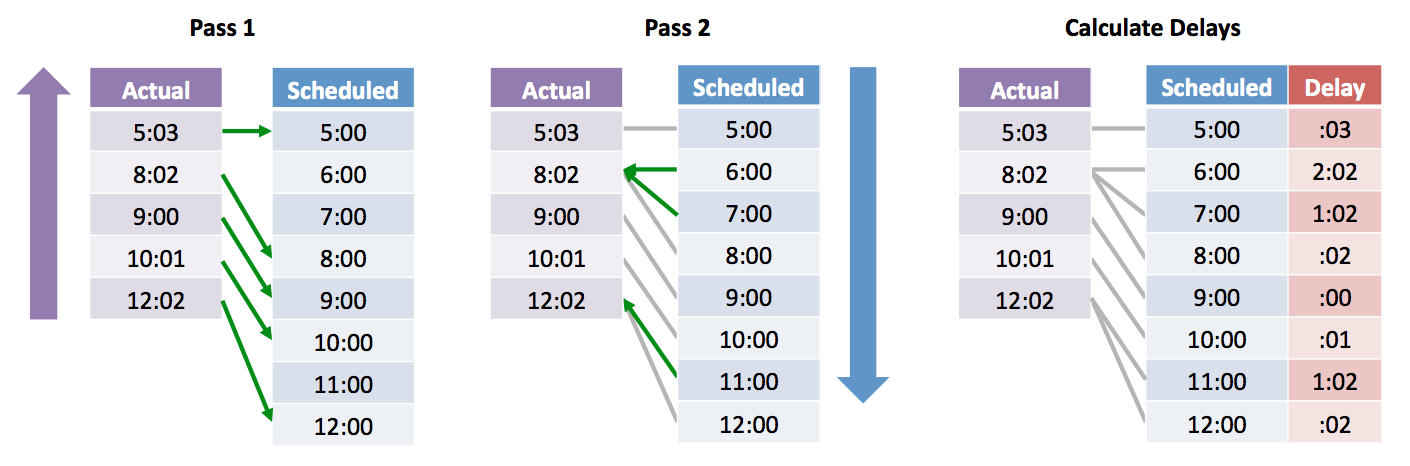

In [190]:
Image(filename='approach1.png')

There are a couple of problems with this approach. First, it is that it assumes trains would never arrive at a station early. This is generally a good assumption, because: 

- Anecdotally, we have never seen a train arrive early, and 
- There is no real incentive for a train operator to arrive early. 

However, as it turns out, this is not the case. And when there is a train that arrives early, it can propogate the miscalculation of delays across the day, as it is depicted below.

We came up with a fix for this issue, as follows: Before making a backward pass, we add 60 seconds to the actual time, the make our passes, and at the end subtract 60 seconds from the delays calculated. This mostly gets rid of having to rely on the assumption above, but there are still cases where train arrives more than 60 seconds ahead of schedule. We can subtract more, but run the risk of subtracting too much and propogating miscalculation. So this is still an issue.

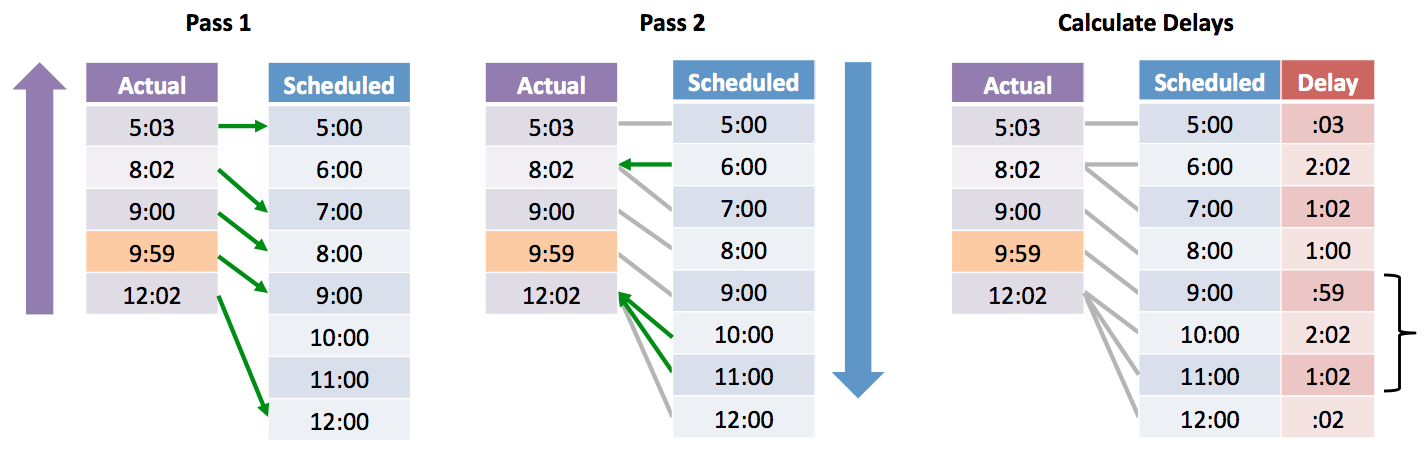

In [189]:
Image(filename='approach1fix.png')

Upon further examination of the results, we saw that there are also cases when a train sits at the station for longer than our previously determined threshold. When this happens, we consider a single train at a station to be two trains arriving very close to each other.

We considered several options before settling on what we consider to be the best approach to calculating delays which takes care of both problems above.

We first make a pass on the scheduled times, finding the closest [actual time + 60 seconds] that gives a positive delay value that is less than an hour. If we have a value, we subtract 60 seconds and assign that value as the delay. If in the first pass we didn't find a delay value, we then make another pass, this time associating each scheduled time to the smallest actual value larger than the scheduled time.

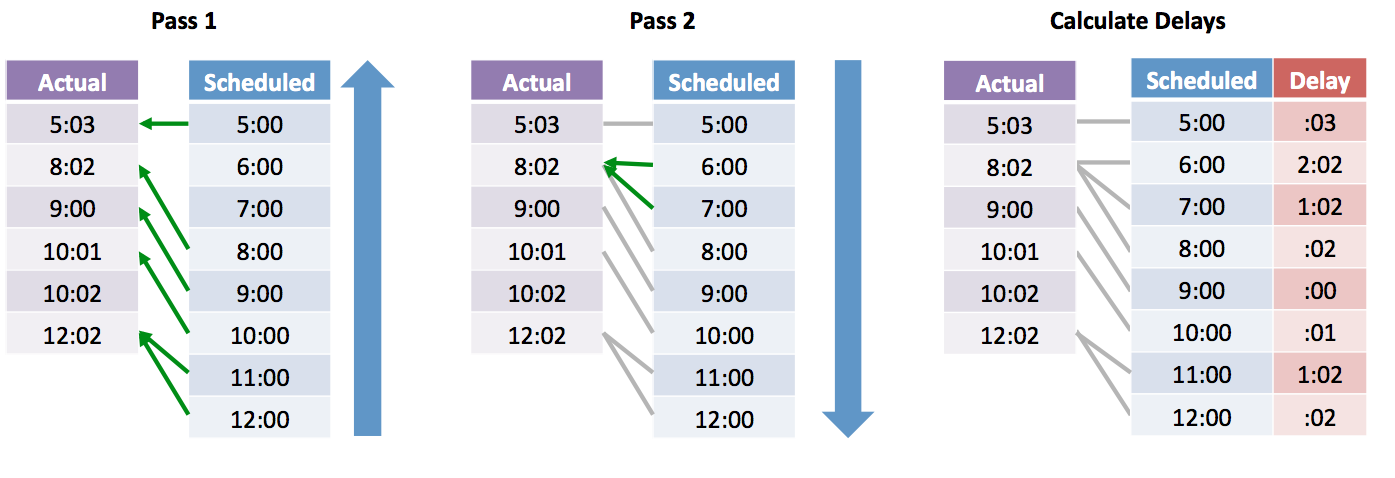

In [209]:
Image(filename='finalapproach.png')

In [230]:
delays = pd.DataFrame(columns = sched.columns.append(np.asarray(['delay', 'actual'])))

dates = list(sched['train_date'].unique())[1:-1]
print "calculating delays for "+str(len(dates))+" dates."

for ii, d in enumerate(dates):
    sched_d = sched[sched['train_date']==d]
    rock_ld = rock_l[rock_l['train_date']==d]
    if sched_d.shape[0] < rock_ld.shape[0]:
        continue

    sched_d['delay'] = np.NaN
    sched_d['actual'] = ""
    sched_d = sched_d.sort('train_date_time', ascending = False).reset_index(drop = True)
    rock_ld = rock_ld.sort('train_date_time', ascending = False).reset_index(drop = True)
    
    for j, rows in rock_ld.iterrows():
        mindist = 3600
        m = np.NaN
        act = ""
        for i, rowr in sched_d.iterrows():
            if (((rock_ld.ix[j]['train_date_time']+datetime.timedelta(seconds=60)-sched_d.ix[i]['train_date_time']).total_seconds()>0)and(((rock_ld.ix[j]['train_date_time']+datetime.timedelta(seconds=60)-sched_d.ix[i]['train_date_time']).total_seconds())<mindist)):
                mindist = (rock_ld.ix[j]['train_date_time'] - sched_d.ix[i]['train_date_time']).total_seconds()
                m = i
                act = rock_ld.ix[j]['train_date_time']
        sched_d['delay'][m] = (rock_ld.ix[j]['train_date_time'] - sched_d.ix[m]['train_date_time']).total_seconds()
        sched_d['actual'][m] = act


    rock_ld = rock_l[rock_l['train_date']==d]
    sched_d = sched_d.sort('train_date_time', ascending = True).reset_index(drop = True)
    rock_ld = rock_ld.sort('train_date_time', ascending = True).reset_index(drop = True)
    
    for i, rows in sched_d.iterrows():
        if np.isnan(sched_d['delay'][i]) == True:
            for j, rowr in rock_ld.iterrows():
                if (rock_ld.ix[j]['train_date_time'] + datetime.timedelta(seconds = 60)) >= sched_d.ix[i]['train_date_time']:
                    sched_d['delay'][i] = (rock_ld.ix[j]['train_date_time'] - sched_d.ix[i]['train_date_time']).total_seconds()
                    sched_d['actual'][i] = rock_ld.ix[j]['train_date_time']
                    break

    delays = delays.append(sched_d)

delays['six'] = delays['delay'].apply(lambda x: 1 if x > 600 else 0)

calculating delays for 71 dates.


Distribution of delays:

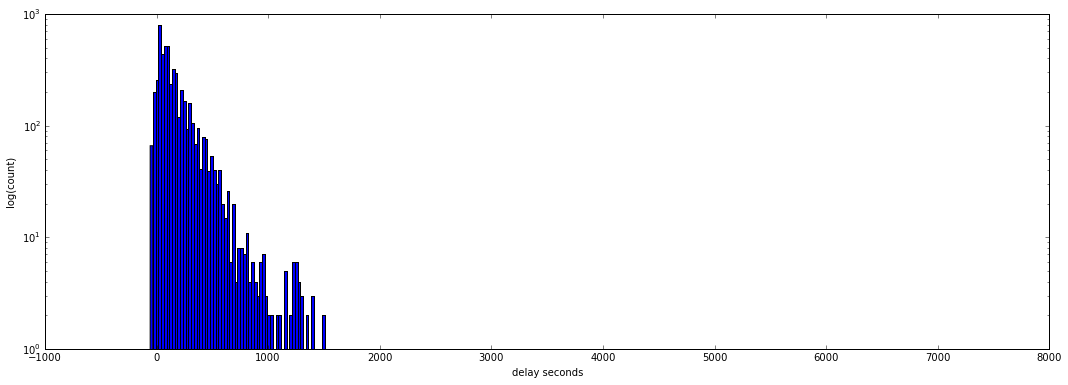

In [240]:
ax = plt.figure(figsize=(18, 6))
ax = plt.hist(list(delays['delay']), 300, log = True)
ax = plt.xlabel('delay seconds')
ax = plt.ylabel('log(count)')

Delays over time:

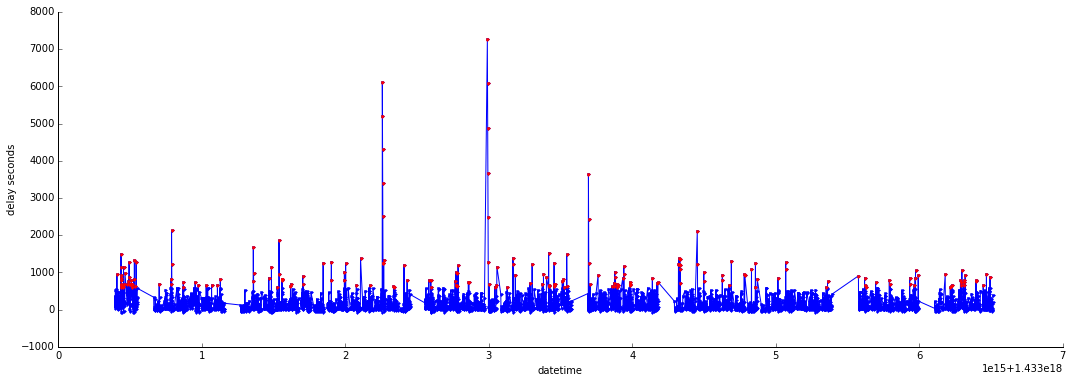

In [241]:
plt.figure(figsize=(18, 6))
plt.plot(delays.date_time, delays.delay, '-b.')
plt.plot(delays[delays['delay']>600].date_time, delays[delays['delay']>600].delay, 'r.')
plt.xlabel('datetime')
plt.ylabel('delay seconds')
remove_border()
plt.show()

Sample of delays for one day:

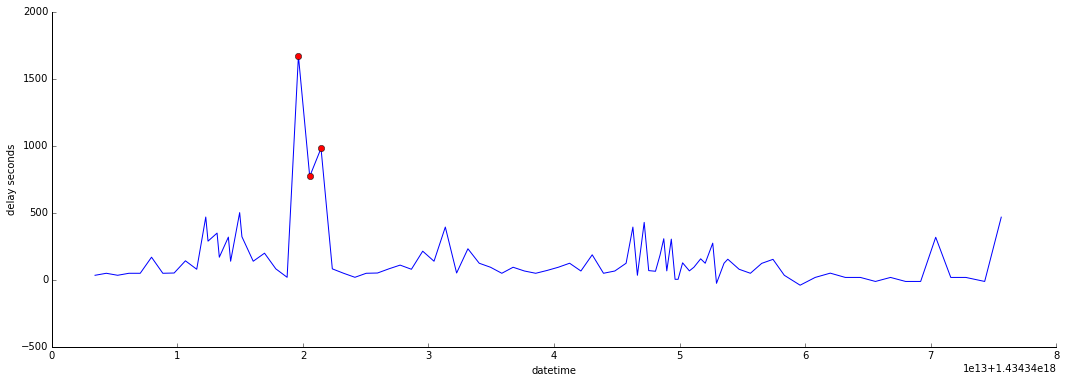

In [242]:
d = '2015-06-15'
plt.figure(figsize=(18, 6))
plt.plot(delays2[(delays['train_date']==d)].date_time, \
         delays2[(delays['train_date']==d)].delay)
plt.plot(delays2[(delays['delay']>600)&(delays['train_date']==d)].date_time, \
         delays2[(delays['delay']>600)&(delays['train_date']==d)].delay, 'ro')
plt.xlabel('datetime')
plt.ylabel('delay seconds')
remove_border()
plt.show()

#Exploring the Weather Data

The three closest points we have weather data on close to Rockridge are Berkeley, Emeryville, and Piedmont. We chose to look at the data for Piedmont, since the statistics for the three locations are likely very similar.

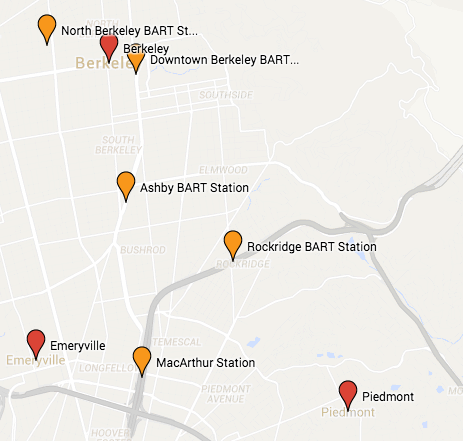

In [243]:
Image(filename = 'rockridgeweathermap.png')

##Forecast

In [301]:
columns = ['reception_time', 'location', 'clouds_9', 'humidity_9', 'pressure_pres_9', 'rain_9', \
           'status_9', 'temperature_temp_9', 'visibility_dist_9', 'wind_deg_9', 'wind_speed_9', \
           'clouds_12', 'humidity_12', 'pressure_pres_12', 'rain_12', 'status_12', 'temperature_temp_12', \
           'visibility_dist_12', 'wind_deg_12', 'wind_speed_12']
weather_forecast = exec_pd("""select reception_time, location, clouds_9, humidity_9, pressure_pres_9, rain_9,
status_9, temperature_temp_9, visibility_dist_9, wind_deg_9, wind_speed_9, clouds_12, humidity_12,
pressure_pres_12, rain_12, status_12, temperature_temp_12, visibility_dist_12, wind_deg_12, wind_speed_12
from weather_forecast where location = 'Piedmont'""")
weather_forecast.columns = columns
weather_forecast.head()

,reception_time,location,clouds_9,humidity_9,pressure_pres_9,rain_9,status_9,temperature_temp_9,visibility_dist_9,wind_deg_9,wind_speed_9,clouds_12,humidity_12,pressure_pres_12,rain_12,status_12,temperature_temp_12,visibility_dist_12,wind_deg_12,wind_speed_12
0,2015-06-26 01:27:32,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
1,2015-06-26 01:28:07,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
2,2015-06-26 01:28:46,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
3,2015-06-26 01:29:22,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66
4,2015-06-26 01:29:58,Piedmont,0,100,1017.53,0,clear,288.36,0,228.003,1.22,0,100,1017.58,0,clear,287.02,0,275.502,0.66


Here we transform the reception to datetime. For the modeling dataframe, we need to create a join key t that says what was forceast for time t 12 hours ago? what was forecast for t-3? Essentially we want to use the forecast of weather 9 and 12 hours into the future as features for predicting delay 12 hours into the future.

In [302]:
weather_forecast['date_time'] = pd.to_datetime(weather_forecast['reception_time'], format = "%Y-%m-%d %H:%M:%S")
weather_forecast['curr_time'] = weather_forecast['date_time'] + datetime.timedelta(hours = 12)

#round to nearest minute
weather_forecast['curr_time_rounded'] = weather_forecast['curr_time'].apply(lambda x: x - datetime.timedelta(seconds=x.second, microseconds=x.microsecond))

##Current

In [305]:
columns = ['reception_time', 'location', 'clouds', 'humidity', 'pressure_pres', 'rain', \
           'status', 'temperature_temp', 'visibility_dist', 'wind_deg', 'wind_speed']
weather_current = exec_pd("""select reception_time, location, clouds, humidity, pressure_pres, rain, 
status, temperature_temp, visibility_dist, wind_deg, wind_speed from weather_current 
where location = 'Piedmont'""")
weather_current.columns = columns
weather_current.head()

,reception_time,location,clouds,humidity,pressure_pres,rain,status,temperature_temp,visibility_dist,wind_deg,wind_speed
0,2015-06-28 03:46:07,Piedmont,90,77,1016,0,clouds,289.64,0,320,4.1
1,2015-06-28 03:46:43,Piedmont,90,77,1016,0,clouds,289.64,0,320,4.1
2,2015-06-28 03:47:18,Piedmont,90,77,1016,0,clouds,289.64,0,320,4.1
3,2015-06-28 03:47:53,Piedmont,90,77,1016,0,clouds,289.64,0,320,4.1
4,2015-06-28 03:48:28,Piedmont,90,77,1016,0,clouds,289.64,0,320,4.1


##Comparing 9- and 12-hour forecasts to actual values

In [346]:
forecast_compare = weather_forecast[['date_time', 'temperature_temp_9', 'pressure_pres_9', 'temperature_temp_12', 'pressure_pres_12' ]]
forecast_compare['curr_time_12'] = forecast_compare['date_time'] + datetime.timedelta(hours = 12)
forecast_compare['curr_time_9'] = forecast_compare['date_time'] + datetime.timedelta(hours = 9)

#round to nearest minute
forecast_compare['curr_time_12_rounded'] = forecast_compare['curr_time_12'].apply(lambda x: x - datetime.timedelta(seconds=x.second, microseconds=x.microsecond))
forecast_compare['curr_time_9_rounded'] = forecast_compare['curr_time_9'].apply(lambda x: x - datetime.timedelta(seconds=x.second, microseconds=x.microsecond))

current_compare = weather_current[['reception_time', 'pressure_pres', 'temperature_temp']]
current_compare['date_time'] = pd.to_datetime(current_compare['reception_time'], format = "%Y-%m-%d %H:%M:%S")

#round to nearest minute
current_compare['curr_time_rounded'] = current_compare['date_time'].apply(lambda x: x - datetime.timedelta(seconds=x.second, microseconds=x.microsecond))

In [347]:
current_compare = current_compare[['curr_time_rounded', 'pressure_pres', 'temperature_temp']].drop_duplicates()
current_compare = current_compare.reset_index(drop = True)

forecast_compare_12 = forecast_compare[['curr_time_12_rounded', 'pressure_pres_12', 'temperature_temp_12']].drop_duplicates()
forecast_compare_12 = forecast_compare_12.reset_index(drop = True)

forecast_compare_9 = forecast_compare[['curr_time_9_rounded', 'pressure_pres_9', 'temperature_temp_9']].drop_duplicates()
forecast_compare_9 = forecast_compare_9.reset_index(drop = True)

compare_12 = current_compare.merge(forecast_compare_12, how = 'inner', left_on = 'curr_time_rounded', right_on = 'curr_time_12_rounded')
compare_9 = current_compare.merge(forecast_compare_9, how = 'inner', left_on = 'curr_time_rounded', right_on = 'curr_time_9_rounded')

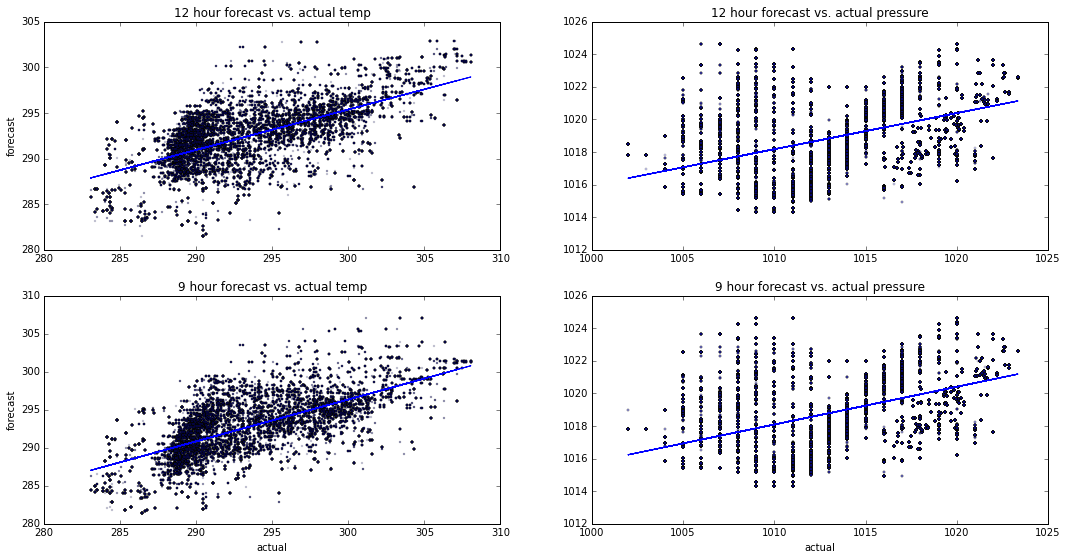

In [348]:
fig = plt.figure(figsize = (18, 9))
ax1 = fig.add_subplot(221)
ax1 = plt.scatter(compare_12.temperature_temp, compare_12.temperature_temp_12, alpha = 0.2, s = 2)
m, b = np.polyfit(compare_12.temperature_temp, compare_12.temperature_temp_12, 1)
ax1 = plt.plot(compare_12.temperature_temp, m*compare_12.temperature_temp + b, '-')
ax1 = plt.title('12 hour forecast vs. actual temp')
ax1 = plt.ylabel('forecast')
ax2 = fig.add_subplot(222) 
ax2 = plt.scatter(compare_12.pressure_pres, compare_12.pressure_pres_12, alpha = 0.2, s = 4)
m, b = np.polyfit(compare_12.pressure_pres, compare_12.pressure_pres_12, 1)
ax2 = plt.plot(compare_12.pressure_pres, m*compare_12.pressure_pres + b, '-')
ax2 = plt.title('12 hour forecast vs. actual pressure')

ax3 = fig.add_subplot(223)
ax3 = plt.scatter(compare_9.temperature_temp, compare_9.temperature_temp_9, alpha = 0.2, s = 2)
m, b = np.polyfit(compare_9.temperature_temp, compare_9.temperature_temp_9, 1)
ax3 = plt.plot(compare_9.temperature_temp, m*compare_9.temperature_temp + b, '-')
ax3 = plt.title('9 hour forecast vs. actual temp')
ax3 = plt.ylabel('forecast')
ax3 = plt.xlabel('actual')
ax4 = fig.add_subplot(224) 
ax4 = plt.scatter(compare_9.pressure_pres, compare_9.pressure_pres_9, alpha = 0.2, s = 4)
m, b = np.polyfit(compare_9.pressure_pres, compare_9.pressure_pres_9, 1)
ax4 = plt.plot(compare_9.pressure_pres, m*compare_9.pressure_pres + b, '-')
ax4 = plt.title('9 hour forecast vs. actual pressure')
ax4 = plt.xlabel('actual')

#Building the Modeling DataFrame

In order to start modeling, we pull in data from both the BART datasets and the weather datasets.

First we merge Delays with Weather Forecast, add hour, day of week, and load.

In [294]:
modeldf = delays.merge(weather_forecast, how = 'inner', left_on = 'date_time', right_on = 'curr_time_rounded')
modeldf['weekday'] = modeldf['date_time_x'].apply(lambda x: x.isoweekday())
modeldf['hour'] = modeldf['date_time_x'].apply(lambda x: x.hour)
modeldf = modeldf.merge(sched_load, how = 'inner', on = ['station', 'train', 'route'])

We then tie in load at previous station (McArthur). Load only applies to weekdays, so for weekends we need to assign it a value distinct from others. We assign 0. We will then dummify it.

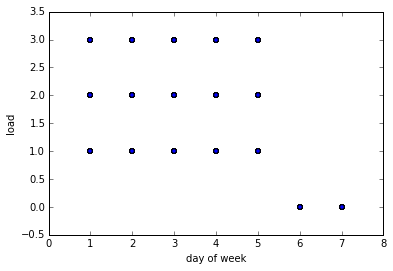

In [295]:
prev_load = sched_load[(sched_load['station']=='MCAR')&(sched_load['route']==2)][['train', 'passload']]
modeldf = modeldf.merge(prev_load, how = 'inner', on = 'train', suffixes = ['', '_prev'])
modeldf['passload'][(modeldf['weekday']==6)|(modeldf['weekday']==7)] = 0
modeldf['passload_prev'][(modeldf['weekday']==6)|(modeldf['weekday']==7)] = 0

#dummify load and prevload
modeldf['load_low'] = modeldf['passload'].apply(lambda x: 1 if x == 1 else 0)
modeldf['load_med'] = modeldf['passload'].apply(lambda x: 1 if x == 2 else 0)
modeldf['load_high'] = modeldf['passload'].apply(lambda x: 1 if x == 3 else 0)
modeldf['prevload_low'] = modeldf['passload_prev'].apply(lambda x: 1 if x == 1 else 0)
modeldf['prevload_med'] = modeldf['passload_prev'].apply(lambda x: 1 if x == 2 else 0)
modeldf['prevload_high'] = modeldf['passload_prev'].apply(lambda x: 1 if x == 3 else 0)

ax = plt.scatter(modeldf.weekday, modeldf.passload)
ax = plt.xlabel('day of week')
ax = plt.ylabel('load')

We then choose the columns to model on, and drop duplicates we created when we rounded weather datetimes to closest minute.

In [296]:
modeling_columns = ['clouds_9', 'humidity_9', 'pressure_pres_9', 'rain_9', 'temperature_temp_9', \
                    'wind_deg_9', 'wind_speed_9', 'clouds_12', 'humidity_12', \
                    'pressure_pres_12', 'rain_12', 'temperature_temp_12', \
                    'wind_deg_12', 'wind_speed_12', 'weekday', 'hour', 'load_low', \
                    'load_med', 'load_high', 'prevload_low', 'prevload_med', \
                    'prevload_high', 'delay']
modeldf = modeldf[modeling_columns]
modeldf = modeldf.drop_duplicates()
modeldf = modeldf.reset_index(drop = True)
modeldf.head()

,clouds_9,humidity_9,pressure_pres_9,rain_9,temperature_temp_9,wind_deg_9,wind_speed_9,clouds_12,humidity_12,pressure_pres_12,...,wind_speed_12,weekday,hour,load_low,load_med,load_high,prevload_low,prevload_med,prevload_high,delay
0,0,100,1017.25,0,284.04,210.000,2.51,32,100,1017.25,...,2.21,2,12,1,0,0,1,0,0,109
1,12,100,1017.88,0,284.02,218.001,1.50,32,100,1017.38,...,1.21,3,12,1,0,0,1,0,0,19
2,8,100,1018.30,0,284.43,210.504,1.92,0,100,1018.78,...,1.86,4,12,1,0,0,1,0,0,49
3,0,100,1020.06,0,284.36,223.503,2.11,0,100,1019.66,...,2.01,5,12,1,0,0,1,0,0,259
4,20,97,1017.38,0,285.97,211.003,1.51,12,76,1017.55,...,1.41,6,17,0,0,0,0,0,0,109


Scatter Matrix of the first 14 variables:

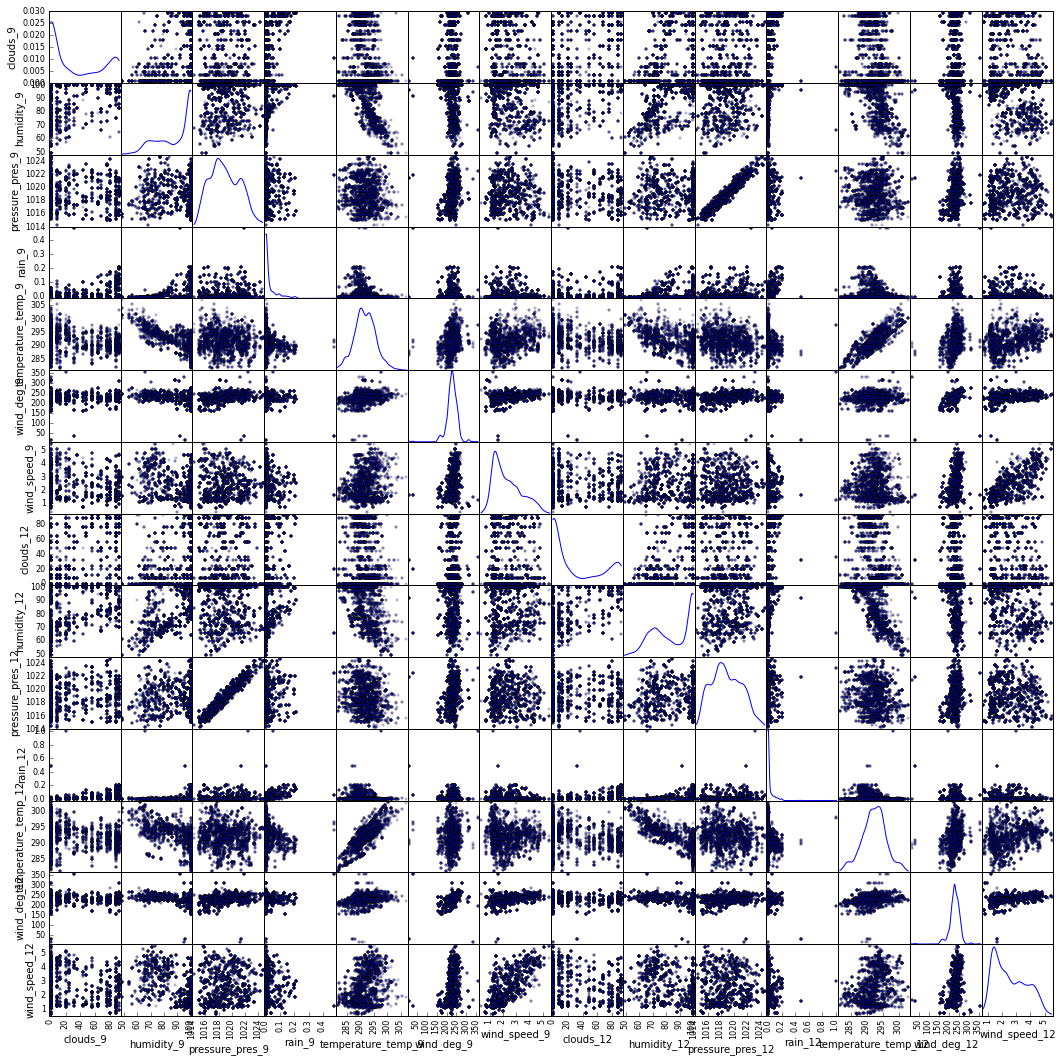

In [266]:
fig = pd.tools.plotting.scatter_matrix(modeldf.ix[:,:14], alpha=0.2, figsize=(18, 18), diagonal='kde')

##Split Train and Dev

We initially did a 80/20 split of the data for building the training and validation sets. Later we moved to using cross-validation, since we suspected the dataset might be too small. We did not set aside a test set, as we considered the data that is yet to be captured to be our test set moving forward.

In [281]:
#80/20 split
ind = np.random.permutation(len(modeldf))
train_index = ind[:int(len(modeldf)*.8)]
dev_index = ind[int(len(modeldf)*.8):]

traindf = modeldf.ix[train_index,:-1]
trainlabeldf = modeldf.ix[train_index,-1]
train = traindf.values
trainlabel = trainlabeldf.values

devdf = modeldf.ix[dev_index,:-1]
devlabeldf = modeldf.ix[dev_index,-1]
dev = devdf.values
devlabel = devlabeldf.values

In [297]:
#kfold
traindf = modeldf.ix[:,:-1]
trainlabeldf = modeldf.ix[:,-1]
X = traindf.values
Y = trainlabeldf.values

#Build the model

We started with a simple ridge regression model with a continuous variable outcome, then moved to several iterations of random forest regression models, and later switched to a binary outcome variable, setting our delay thresholds at 300 and 600 and ran through setting up various logisitic regression and random forest classification models. We also played around with predicting delays closer to the desired time (6 hours instead of 12 hours out). In all cases, we were not able to extract any signal from the variables we had incuded in our model in predicting the outcome variable.

In [275]:
#ridge
clf = Ridge(0.5)
clf.fit(train, trainlabel)
y_pred = clf.predict(dev)
print "r2: "+str(clf.score(dev, devlabel))

r2: 0.0295420102318


In [299]:
#random forest
kf = KFold(len(X), n_folds=10)
scores = []
for k , (t_ind, d_ind) in enumerate(kf):
    rf = RandomForestRegressor(n_estimators=500)
    rf.fit(X[t_ind], Y[t_ind])
    y_pred = rf.predict(X[d_ind])
    score = rf.score(X[d_ind], Y[d_ind])
    scores.append(score)
    print k, score

scores = np.array(scores)
print("r2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0 -0.0755600715207
1 -0.882444173321
2 -0.328159959706
3 -1.57941294621
4 0.0524851181743
5 -0.164713320868
6 -0.0260268670639
7 -0.207103463657
8 -0.0757198539104
9 -0.177056911796
r2: -0.35 (+/- 0.96)


###Binarize outcome variable
Gives us no better results

In [291]:
modeldf['delay'] = modeldf['delay'].apply(lambda x: 1 if x >= 300 else 0)

#kfold
traindf = modeldf.ix[:,:-1]
trainlabeldf = modeldf.ix[:,-1]
X = traindf.values
Y = trainlabeldf.values

In [293]:
#random forest
kf = KFold(len(X), n_folds=10)
scores = []
f1s = []
for k , (t_ind, d_ind) in enumerate(kf):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X[t_ind], Y[t_ind])
    y_pred = rf.predict(X[d_ind])
    score = rf.score(X[d_ind], Y[d_ind])
    f1 = metrics.f1_score(Y[d_ind], y_pred)
    scores.append(score)
    f1s.append(f1)
    print k, score, f1

scores = np.array(scores)
f1s = np.array(f1s)
print("accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("f1: %0.2f (+/- %0.2f)" % (f1s.mean(), f1s.std() * 2))

0 0.891358024691 0.153846153846
1 0.646913580247 0.153846153846
2 0.622222222222 0.231155778894
3 0.673267326733 0.3125
4 0.831683168317 0.227272727273
5 0.883663366337 0.078431372549
6 0.868811881188 0.131147540984
7 0.673267326733 0.241379310345
8 0.747524752475 0.190476190476
9 0.836633663366 0.131578947368
accuracy: 0.77 (+/- 0.20)
f1: 0.19 (+/- 0.13)


For an explanation of how R^2 can be negative, see here: http://stats.stackexchange.com/questions/12900/when-is-r-squared-negative?lq=1

It is clear that we are not able extract enough signal from the variables we have chosen to predict delays. There are number of factors that can be contributing to this:

- **Not enough data**: We have about 2 months of data. It is possible that, if we have more data, we might be able to start seeing patterns emerge that we are not able to extract with this limited set.
- **Delays due to various reasons**: There are several factors that contribute to delays. For example, delays due to medical emergencies are very different in nature that delays due to equipment problems. If we had devised a way to distinguish these different cases and build separate models for each, we might have been able to see some predictive power in the data.
- **Miscalculation of delays**: The calculation of delays is not perfect. We have a very good process to come up with reasonable delays, but we could still be miscalculating the delays.
- **Not the right station**: We chose Rockridge to start with because we knew it was a busy station and it was simple to model because there is only one route going through that station. However, given that trains arrive at the station typically every 15 minutes or so, we do not see delays from one train propogate far. So we don't actually see a whole lot of trains be late for a significant amount of time. Had we chosen a stations with more routes, we probably would have seen a larger portion of delayed trains.

#Next Steps

Had we had more time to spend on this project, we would have tried a few more things:

- **Build models for other stations**: As noted above, we might have better data working with a station with more routes going through it.
- **Build more features**: We are missing event data here, as well as other features we could have built.
- **Distinguish different types of delays**: We suspect building different models for different types of delays is crucial in extracting a signal from the features.
